# TabM 模型可视化与可解释性分析

本notebook实现TabM最优模型（tabm_best.pt）的全面可视化分析：
- **SHAP分析**：Summary Plot, Bar Plot, Dependence Plot, Waterfall Plot
- **Captum分析**：Integrated Gradients, Feature Ablation, Saliency
- **LIME分析**：局部可解释性
- **Permutation Importance**：排列重要性

**注意**：数据处理流程严格与 `Tabm_Enhanced.ipynb` 保持一致

## 1. 导入必要的库

In [1]:
import os
import random
import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import tabm
import rtdl_num_embeddings
import torch
import torch.nn as nn

import shap
from captum.attr import IntegratedGradients, FeatureAblation, Saliency
from lime.lime_tabular import LimeTabularExplainer

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")
print(f"SHAP: {shap.__version__}")
print("库导入完成！")

PyTorch: 2.9.1+cu130, CUDA: True
SHAP: 0.50.0
库导入完成！


## 2. 设置参数和路径

In [2]:
os.makedirs("./output/tabm_visualizations", exist_ok=True)
RANDOM_SEED = 825
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"随机种子: {RANDOM_SEED}, 设备: {DEVICE}")

随机种子: 825, 设备: cuda


## 3-6. 数据加载与特征工程

In [3]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_new.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_new.csv")
normal_data["group"], disease_data["group"] = "N", "Y"
data = pd.concat([normal_data, disease_data], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")

train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()
y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(
    f"训练集: {len(X_train)}, 验证集: {len(X_validation)}, 特征数: {len(feature_cols)}"
)

训练集: 13736, 验证集: 5888, 特征数: 38


## 7. 数据预处理（缺失值填充）

In [4]:
# 加载保存的预处理器
tabm_preprocessors = joblib.load("./output/models/tabm_preprocessors.pkl")
saved_imputer = tabm_preprocessors.get("imputer", None)
saved_scaler = tabm_preprocessors.get("scaler", None)
print(
    f"加载的预处理器: imputer={saved_imputer is not None}, scaler={saved_scaler is not None}"
)

categorical_info = {
    "Tanner分期": (1, 5),
    "乳晕色素沉着": (0, 2),
    "乳核": (0, 1),
    "有无阴毛": (0, 1),
    "有无腋毛": (0, 1),
}
categorical_cols = [c for c in categorical_info.keys() if c in feature_cols]
numerical_cols = [c for c in feature_cols if c not in categorical_cols]

# 分类特征填补（需重新fit，因为没有保存cat_imputer）
cat_imputer = IterativeImputer(
    estimator=RandomForestClassifier(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)
X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols])
X_validation_cat = cat_imputer.transform(X_validation[categorical_cols])
for i, col in enumerate(categorical_cols):
    min_val, max_val = categorical_info[col]
    X_train_cat[:, i] = X_train_cat[:, i].clip(min_val, max_val)
    X_validation_cat[:, i] = X_validation_cat[:, i].clip(min_val, max_val)

# 数值特征填补（使用保存的imputer）
if saved_imputer is not None:
    print("使用保存的 IterativeImputer")
    X_train_num = saved_imputer.transform(X_train[numerical_cols])
    X_validation_num = saved_imputer.transform(X_validation[numerical_cols])
else:
    print("警告: 未找到保存的imputer，重新fit")
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
        ),
        max_iter=10,
        random_state=RANDOM_SEED,
        verbose=0,
    )
    X_train_num = imputer.fit_transform(X_train[numerical_cols])
    X_validation_num = imputer.transform(X_validation[numerical_cols])

X_train_processed = np.hstack([X_train_cat, X_train_num])
X_validation_processed = np.hstack([X_validation_cat, X_validation_num])
feature_cols_processed = categorical_cols + numerical_cols

valid_features = ~np.isnan(X_train_processed).all(axis=0)
X_train_processed = X_train_processed[:, valid_features]
X_validation_processed = X_validation_processed[:, valid_features]
feature_cols_processed = [
    col for col, valid in zip(feature_cols_processed, valid_features) if valid
]
print(
    f"预处理完成: {X_train_processed.shape[1]}个特征, 缺失值: {np.isnan(X_train_processed).sum()}"
)

加载的预处理器: imputer=True, scaler=True
使用保存的 IterativeImputer
预处理完成: 38个特征, 缺失值: 0


## 8. StandardScaler + 转Tensor

In [5]:
# StandardScaler 只应用于数值特征（与Tabm_Enhanced.ipynb一致）
if saved_scaler is not None:
    print("使用保存的 StandardScaler（仅数值特征）")
    # scaler只对数值特征fit，所以只transform数值部分
    X_train_num_scaled = saved_scaler.transform(X_train_num)
    X_validation_num_scaled = saved_scaler.transform(X_validation_num)
else:
    print("警告: 未找到保存的scaler，使用新的StandardScaler")
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train_num)
    X_validation_num_scaled = scaler.transform(X_validation_num)

# 合并分类特征和标准化后的数值特征
X_train_transformed = np.hstack([X_train_cat, X_train_num_scaled])
X_validation_transformed = np.hstack([X_validation_cat, X_validation_num_scaled])

X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.long).to(DEVICE)
X_val_tensor = torch.tensor(X_validation_transformed, dtype=torch.float32).to(DEVICE)
y_val_tensor = torch.tensor(y_validation_binary.values, dtype=torch.long).to(DEVICE)
print(f"张量: 训练{X_train_tensor.shape}, 验证{X_val_tensor.shape}")

使用保存的 StandardScaler（仅数值特征）
张量: 训练torch.Size([13736, 38]), 验证torch.Size([5888, 38])


## 9. 加载最佳TabM模型

In [6]:
print("=" * 70)
print("加载最佳TabM模型")
print("=" * 70)

tabm_data = joblib.load("./output/models/tabm_preprocessors.pkl")
best_model_name = tabm_data.get("best_model_name", "basic")
saved_metrics = tabm_data.get("metrics", {})
print(f"最佳模型: TabM-{best_model_name}")

model_kwargs = {
    "n_num_features": X_train_tensor.shape[1],
    "cat_cardinalities": [],
    "d_out": 2,
}
n_bins, d_embedding, use_periodic = 48, 16, False

if best_model_name == "hpo":
    hpo_config_path = "./output/tabm_enhanced/models/tabm_hpo_config.pkl"
    if os.path.exists(hpo_config_path):
        hpo_data = joblib.load(hpo_config_path)
        best_params = hpo_data["best_params"]
        n_bins, d_embedding = best_params["n_bins"], best_params["d_embedding"]
        model_kwargs.update(
            {
                "n_blocks": best_params["n_blocks"],
                "d_block": best_params["d_block"],
                "dropout": best_params["dropout"],
            }
        )
        print(
            f"HPO参数: n_blocks={best_params['n_blocks']}, d_block={best_params['d_block']}"
        )
elif best_model_name == "mini":
    model_kwargs["arch_type"] = "tabm-mini"
elif best_model_name == "periodic":
    use_periodic = True

if use_periodic:
    num_embeddings = rtdl_num_embeddings.PeriodicEmbeddings(
        n_features=X_train_tensor.shape[1], d_embedding=d_embedding, lite=False
    )
else:
    num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
        rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=n_bins),
        d_embedding=d_embedding,
        activation=False,
        version="B",
    )
model_kwargs["num_embeddings"] = num_embeddings

tabm_model = tabm.TabM.make(**model_kwargs).to(DEVICE)
tabm_model.load_state_dict(
    torch.load("./output/models/tabm_best.pt", map_location=DEVICE, weights_only=True)
)
tabm_model.eval()
print(f"模型参数量: {sum(p.numel() for p in tabm_model.parameters()):,}")

with torch.no_grad():
    val_logits = tabm_model(X_val_tensor, None)
    y_pred_proba = torch.softmax(val_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
    y_pred = (y_pred_proba >= 0.5).astype(int)
print(
    f"验证集: F1={f1_score(y_validation_binary, y_pred):.4f}, AUC={roc_auc_score(y_validation_binary, y_pred_proba):.4f}"
)

加载最佳TabM模型
最佳模型: TabM-hpo
HPO参数: n_blocks=4, d_block=512
模型参数量: 1,350,912
验证集: F1=0.8436, AUC=0.8864


## 10. 预测函数包装器

In [7]:
def predict_proba_numpy(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = tabm_model(X_tensor, None)
        proba = torch.softmax(logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
    return proba


def predict_proba_numpy_2d(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = tabm_model(X_tensor, None)
        proba = torch.softmax(logits, dim=-1).mean(dim=1).cpu().numpy()
    return proba


print(f"预测函数测试: {predict_proba_numpy(X_validation_transformed[:3])}")

预测函数测试: [0.8548174  0.8397164  0.84310126]


---
# SHAP 可解释性分析

## 11. SHAP值计算

In [8]:
print("=" * 70)
print("SHAP 可解释性分析")
print("=" * 70)

# Top5 重要特征（用于筛选完整数据样本）
top5_features = [
    "左卵巢体积（长X宽X厚X0.5233）",
    "基础血清促黄体生成激素（LH）",
    "卵巢体积平均值",
    "右卵巢体积（长X宽X厚X0.5233）",
    "基础血清卵泡刺激素（FSH）",
]

# 筛选训练集中 top5 特征都非缺失的样本索引
train_complete_mask = X_train[top5_features].notna().all(axis=1)
train_complete_indices = np.where(train_complete_mask.values)[0]
print(f"训练集中 Top5 特征完整样本: {len(train_complete_indices)}/{len(X_train)}")

# 筛选验证集中 top5 特征都非缺失的样本索引
val_complete_mask = X_validation[top5_features].notna().all(axis=1)
val_complete_indices = np.where(val_complete_mask.values)[0]
print(f"验证集中 Top5 特征完整样本: {len(val_complete_indices)}/{len(X_validation)}")

# 从完整样本中选取背景样本
n_background = min(100, len(train_complete_indices))
background_indices = np.random.choice(
    train_complete_indices, n_background, replace=False
)
X_background = X_train_transformed[background_indices]

# 从完整样本中选取待解释样本
n_explain = min(1000, len(val_complete_indices))
explain_indices = np.random.choice(val_complete_indices, n_explain, replace=False)
X_explain = X_validation_transformed[explain_indices]
y_explain = y_validation_binary.iloc[explain_indices].values

print(f"\n背景样本: {n_background}, 待解释样本: {n_explain}")
print("（均为 Top5 特征非插补的真实数据）")
print("计算SHAP值中（可能需要几分钟）...")

explainer = shap.KernelExplainer(predict_proba_numpy, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)

print(f"SHAP值计算完成！形状: {shap_values.shape}")

SHAP 可解释性分析
训练集中 Top5 特征完整样本: 6934/13736
验证集中 Top5 特征完整样本: 2939/5888

背景样本: 100, 待解释样本: 1000
（均为 Top5 特征非插补的真实数据）
计算SHAP值中（可能需要几分钟）...


  0%|          | 0/1000 [00:00<?, ?it/s]

SHAP值计算完成！形状: (1000, 38)


## 12. SHAP Summary Plot (Beeswarm)

生成 SHAP Summary Plot (Beeswarm)...


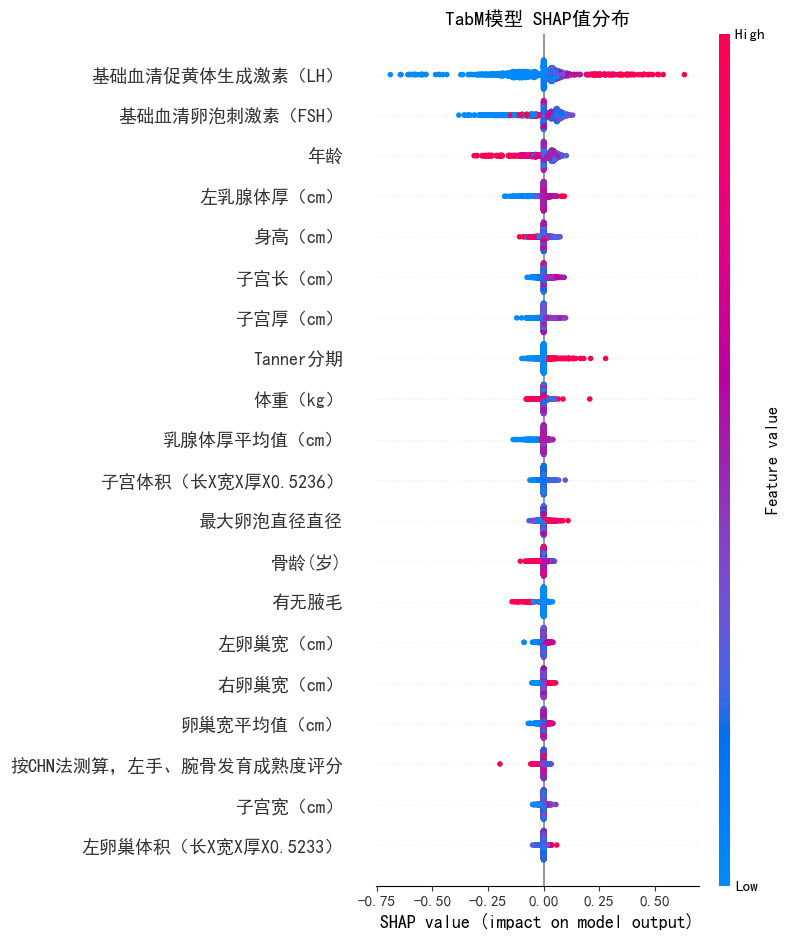

已保存: shap_summary_beeswarm.png/pdf


In [9]:
print("生成 SHAP Summary Plot (Beeswarm)...")
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=feature_cols_processed,
    show=False,
    max_display=20,
)
plt.title("TabM模型 SHAP值分布", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/shap_summary_beeswarm.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/shap_summary_beeswarm.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: shap_summary_beeswarm.png/pdf")

## 13. SHAP Bar Plot (特征重要性)

生成 SHAP Bar Plot...


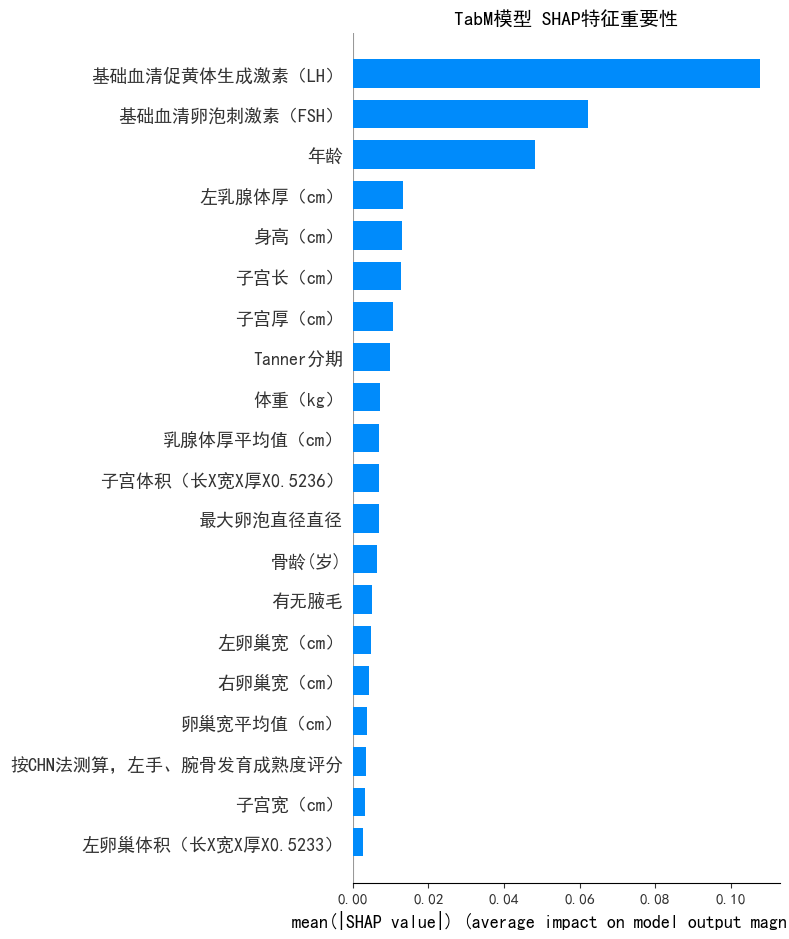


前15个最重要特征:
                特征  SHAP重要性
   基础血清促黄体生成激素（LH） 0.107627
    基础血清卵泡刺激素（FSH） 0.062350
                年龄 0.048150
         左乳腺体厚（cm） 0.013200
            身高（cm） 0.013063
           子宫长（cm） 0.012893
           子宫厚（cm） 0.010723
          Tanner分期 0.009900
            体重（kg） 0.007308
       乳腺体厚平均值（cm） 0.006934
子宫体积（长X宽X厚X0.5236） 0.006860
          最大卵泡直径直径 0.006845
             骨龄(岁) 0.006404
              有无腋毛 0.005201
          左卵巢宽（cm） 0.004901


In [10]:
print("生成 SHAP Bar Plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=feature_cols_processed,
    plot_type="bar",
    show=False,
    max_display=20,
)
plt.title("TabM模型 SHAP特征重要性", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/shap_bar_importance.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabm_visualizations/shap_bar_importance.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

mean_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"特征": feature_cols_processed, "SHAP重要性": mean_shap}
).sort_values("SHAP重要性", ascending=False)
print("\n前15个最重要特征:")
print(feature_importance_df.head(15).to_string(index=False))

## 14. SHAP Dependence Plot (前6个重要特征)

生成 SHAP Dependence Plots...


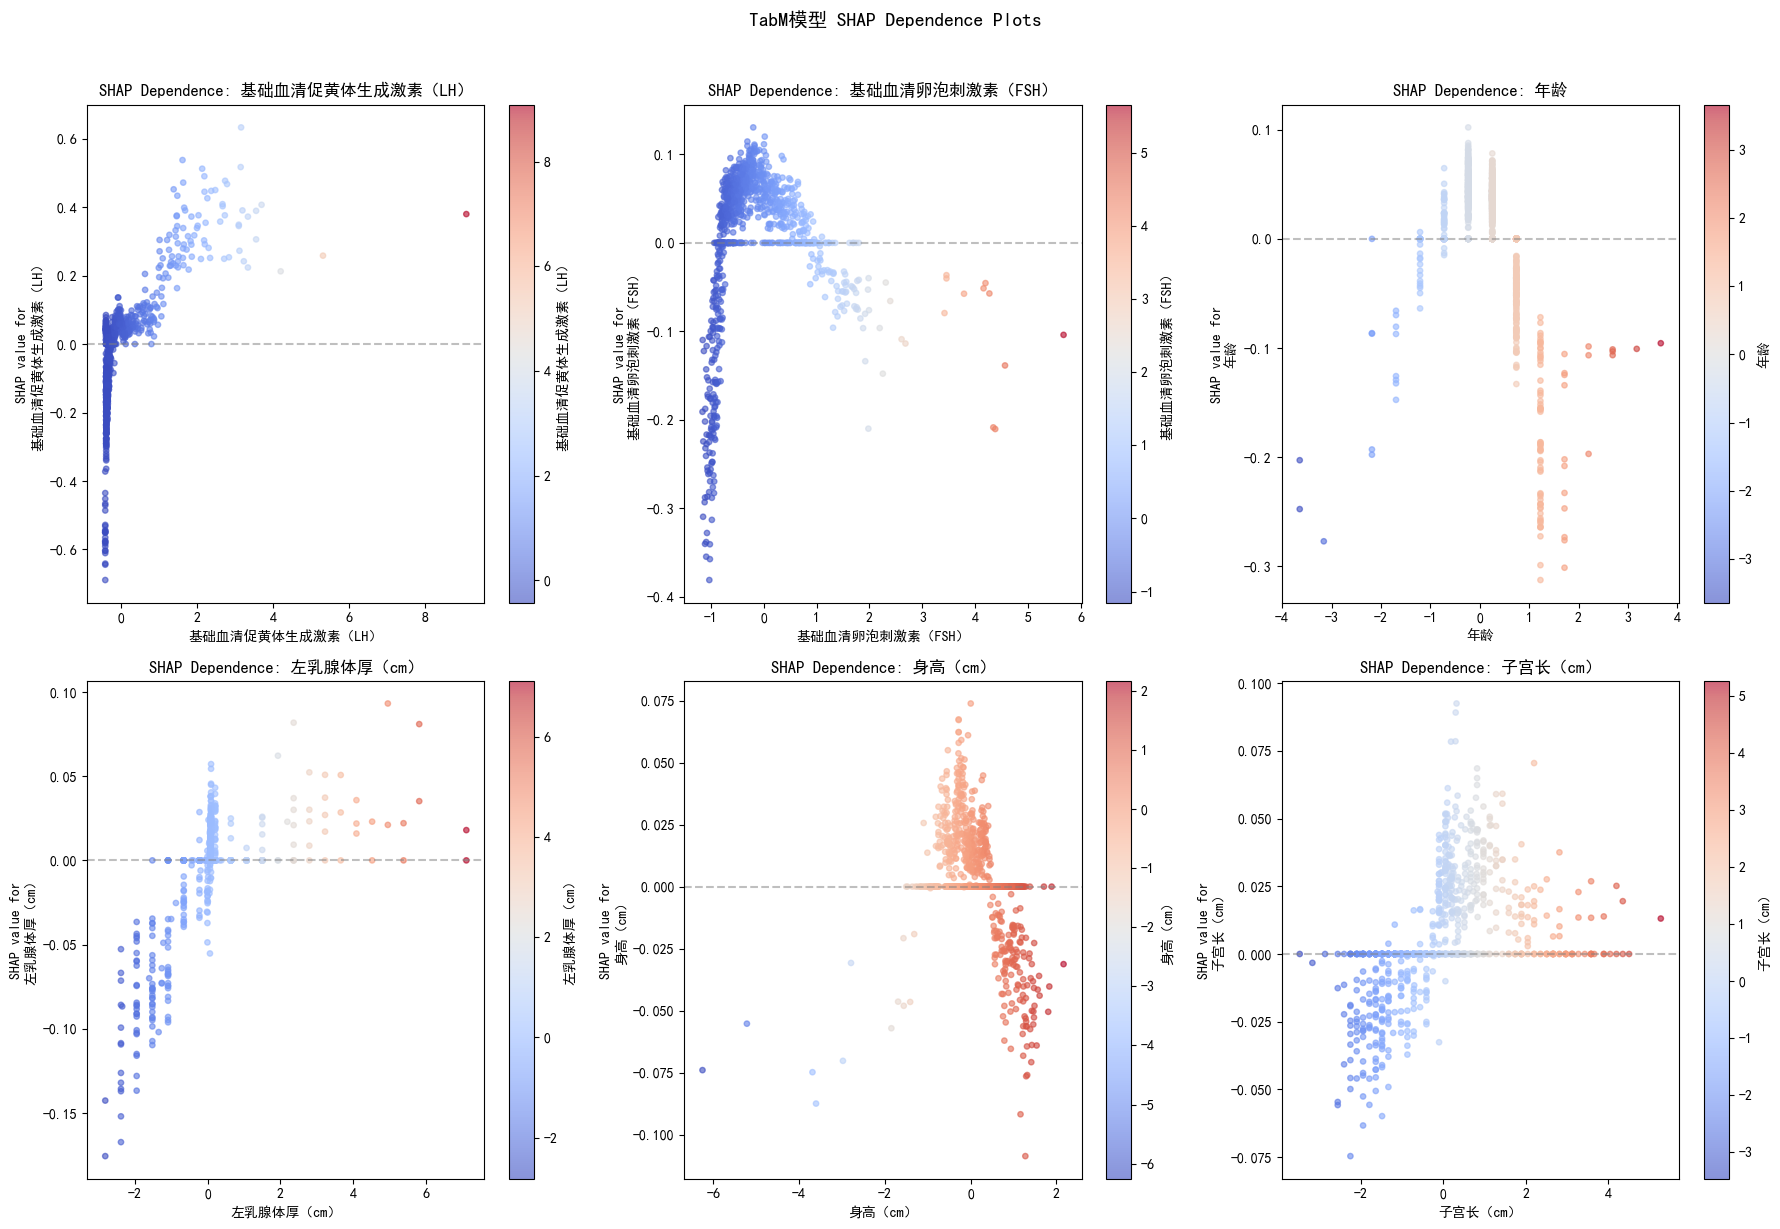

已保存: shap_dependence_top6.png/pdf


In [11]:
print("生成 SHAP Dependence Plots...")
top_features = feature_importance_df.head(6)["特征"].tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature_name in enumerate(top_features):
    feature_idx = feature_cols_processed.index(feature_name)

    x_data = X_explain[:, feature_idx]
    y_data = shap_values[:, feature_idx]

    ax = axes[i]
    scatter = ax.scatter(
        x_data,
        y_data,
        c=X_explain[:, feature_idx],
        cmap="coolwarm",
        alpha=0.6,
        s=15,
    )
    ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
    ax.set_xlabel(feature_name, fontsize=10)
    ax.set_ylabel(f"SHAP value for\n{feature_name}", fontsize=10)
    ax.set_title(f"SHAP Dependence: {feature_name}", fontsize=12, fontweight="bold")
    plt.colorbar(scatter, ax=ax, label=feature_name)

plt.suptitle("TabM模型 SHAP Dependence Plots", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/shap_dependence_top6.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/shap_dependence_top6.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: shap_dependence_top6.png/pdf")

## 15. SHAP Waterfall Plot (正/负样本)

生成 SHAP Waterfall Plots...


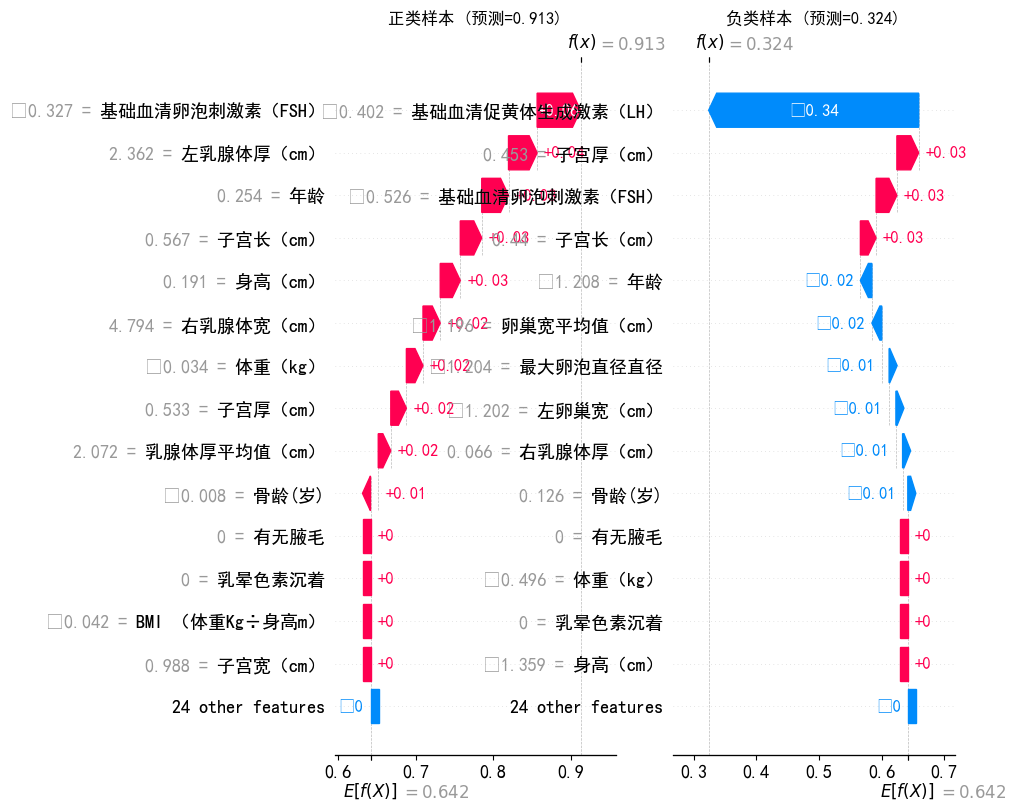

已保存: shap_waterfall.png/pdf


In [12]:
print("生成 SHAP Waterfall Plots...")
positive_idx = np.where(y_explain == 1)[0][0]
negative_idx = np.where(y_explain == 0)[0][0]
base_value = explainer.expected_value

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

plt.subplot(1, 2, 1)
shap_exp_pos = shap.Explanation(
    values=shap_values[positive_idx],
    base_values=base_value,
    data=X_explain[positive_idx],
    feature_names=feature_cols_processed,
)
shap.plots.waterfall(shap_exp_pos, max_display=15, show=False)
plt.title(
    f"正类样本 (预测={predict_proba_numpy(X_explain[positive_idx:positive_idx+1])[0]:.3f})",
    fontsize=12,
    fontweight="bold",
)

plt.subplot(1, 2, 2)
shap_exp_neg = shap.Explanation(
    values=shap_values[negative_idx],
    base_values=base_value,
    data=X_explain[negative_idx],
    feature_names=feature_cols_processed,
)
shap.plots.waterfall(shap_exp_neg, max_display=15, show=False)
plt.title(
    f"负类样本 (预测={predict_proba_numpy(X_explain[negative_idx:negative_idx+1])[0]:.3f})",
    fontsize=12,
    fontweight="bold",
)

plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/shap_waterfall.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabm_visualizations/shap_waterfall.pdf", dpi=300, bbox_inches="tight"
)
plt.show()
print("已保存: shap_waterfall.png/pdf")

## 16. SHAP Force Plot

生成 SHAP Force Plot...


<Figure size 2000x300 with 0 Axes>

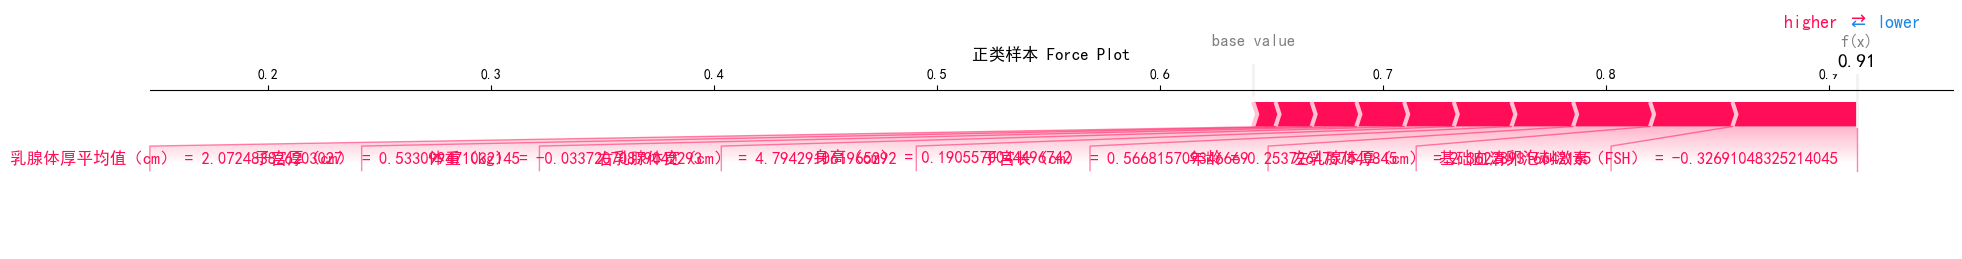

<Figure size 2000x300 with 0 Axes>

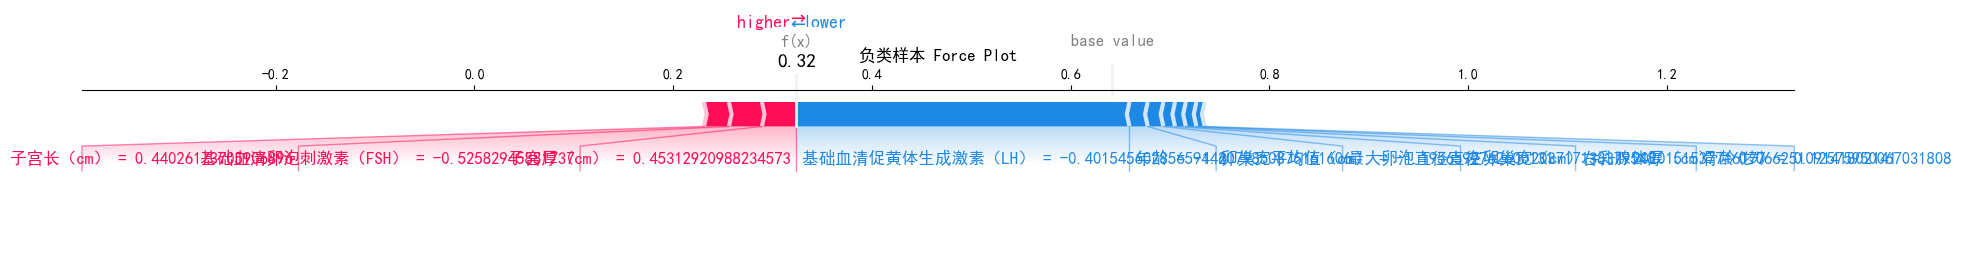

已保存: shap_force_plot_positive.png/pdf, shap_force_plot_negative.png/pdf


In [13]:
print("生成 SHAP Force Plot...")
shap.initjs()

# 正类样本 Force Plot
plt.figure(figsize=(20, 3))
shap.force_plot(
    base_value,
    shap_values[positive_idx],
    X_explain[positive_idx],
    feature_names=feature_cols_processed,
    matplotlib=True,
    show=False,
)
plt.title("正类样本 Force Plot", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/shap_force_plot_positive.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/shap_force_plot_positive.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# 负类样本 Force Plot
plt.figure(figsize=(20, 3))
shap.force_plot(
    base_value,
    shap_values[negative_idx],
    X_explain[negative_idx],
    feature_names=feature_cols_processed,
    matplotlib=True,
    show=False,
)
plt.title("负类样本 Force Plot", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/shap_force_plot_negative.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/shap_force_plot_negative.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("已保存: shap_force_plot_positive.png/pdf, shap_force_plot_negative.png/pdf")

---
# Captum 可解释性分析

## 17. Captum模型包装器

In [14]:
class TabMWrapper(nn.Module):
    """Captum兼容的TabM模型包装器"""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        logits = self.model(x, None)
        proba = torch.softmax(logits, dim=-1).mean(dim=1)
        return proba[:, 1:2]


tabm_wrapper = TabMWrapper(tabm_model)
tabm_wrapper.eval()
print(f"Captum包装器测试: {tabm_wrapper(X_val_tensor[:3]).shape}")

Captum包装器测试: torch.Size([3, 1])


## 18. Integrated Gradients

In [15]:
print("=" * 70)
print("Captum Integrated Gradients 分析")
print("=" * 70)

ig = IntegratedGradients(tabm_wrapper)
n_ig_samples = 300
ig_indices = np.random.choice(
    len(X_validation_transformed), n_ig_samples, replace=False
)
X_ig = torch.tensor(
    X_validation_transformed[ig_indices], dtype=torch.float32, device=DEVICE
)
baseline = (
    torch.tensor(X_train_transformed.mean(axis=0), dtype=torch.float32, device=DEVICE)
    .unsqueeze(0)
    .expand(n_ig_samples, -1)
)

print(f"计算 Integrated Gradients (样本数: {n_ig_samples})...")
ig_attr, delta = ig.attribute(
    X_ig, baselines=baseline, return_convergence_delta=True, n_steps=50
)
ig_attr_np = ig_attr.cpu().detach().numpy()
print(f"完成！形状: {ig_attr_np.shape}, 收敛误差: {delta.abs().mean().item():.6f}")

Captum Integrated Gradients 分析
计算 Integrated Gradients (样本数: 300)...
完成！形状: (300, 38), 收敛误差: 0.069346


生成 Integrated Gradients 特征重要性图...


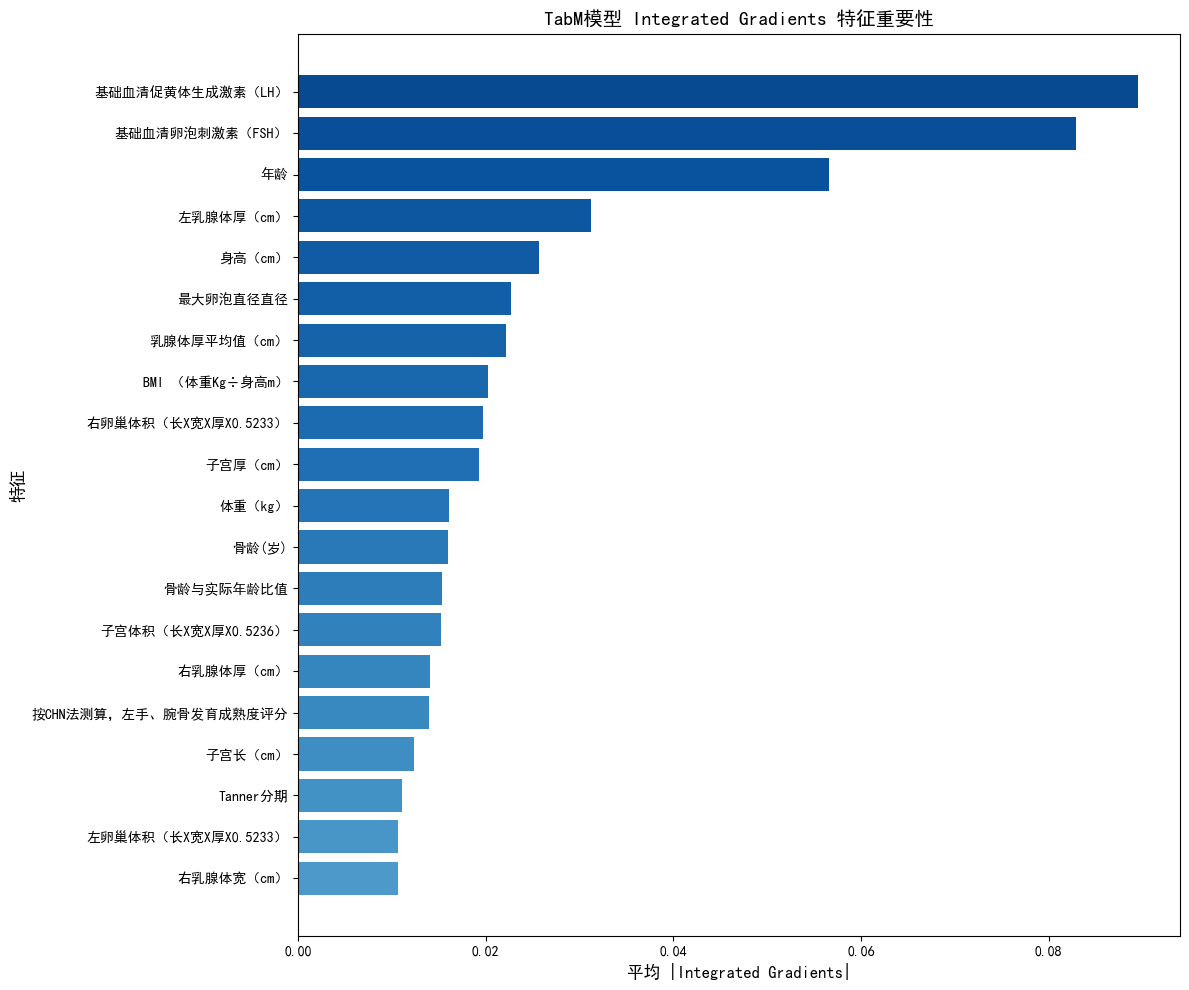

已保存: captum_ig_importance.png/pdf


In [16]:
print("生成 Integrated Gradients 特征重要性图...")
ig_importance = np.abs(ig_attr_np).mean(axis=0)
ig_importance_df = pd.DataFrame(
    {"特征": feature_cols_processed, "IG重要性": ig_importance}
).sort_values("IG重要性", ascending=True)

plt.figure(figsize=(12, 10))
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(ig_importance_df)))
plt.barh(
    ig_importance_df["特征"].tail(20),
    ig_importance_df["IG重要性"].tail(20),
    color=colors[-20:],
)
plt.xlabel("平均 |Integrated Gradients|", fontsize=12)
plt.ylabel("特征", fontsize=12)
plt.title("TabM模型 Integrated Gradients 特征重要性", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/captum_ig_importance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/captum_ig_importance.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: captum_ig_importance.png/pdf")

## 19. Feature Ablation

In [17]:
print("=" * 70)
print("Captum Feature Ablation 分析")
print("=" * 70)

fa = FeatureAblation(tabm_wrapper)
n_fa_samples = 300
fa_indices = np.random.choice(
    len(X_validation_transformed), n_fa_samples, replace=False
)
X_fa = torch.tensor(
    X_validation_transformed[fa_indices], dtype=torch.float32, device=DEVICE
)

print(f"计算 Feature Ablation (样本数: {n_fa_samples})...")
fa_attr = fa.attribute(X_fa)
fa_attr_np = fa_attr.cpu().detach().numpy()
print(f"完成！形状: {fa_attr_np.shape}")

Captum Feature Ablation 分析
计算 Feature Ablation (样本数: 300)...
完成！形状: (300, 38)


生成 Feature Ablation 特征重要性图...


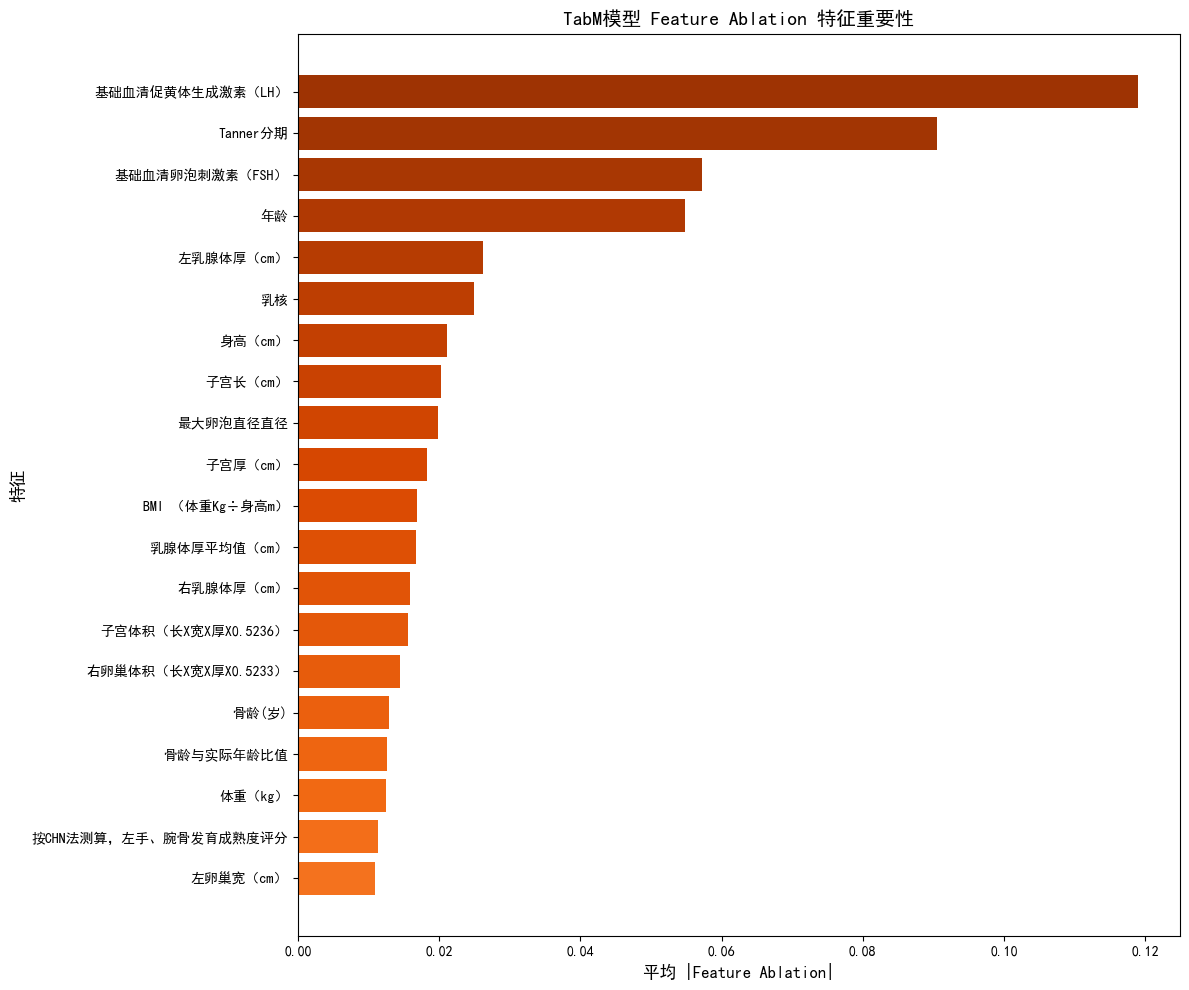

已保存: captum_fa_importance.png/pdf


In [18]:
print("生成 Feature Ablation 特征重要性图...")
fa_importance = np.abs(fa_attr_np).mean(axis=0)
fa_importance_df = pd.DataFrame(
    {"特征": feature_cols_processed, "FA重要性": fa_importance}
).sort_values("FA重要性", ascending=True)

plt.figure(figsize=(12, 10))
colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(fa_importance_df)))
plt.barh(
    fa_importance_df["特征"].tail(20),
    fa_importance_df["FA重要性"].tail(20),
    color=colors[-20:],
)
plt.xlabel("平均 |Feature Ablation|", fontsize=12)
plt.ylabel("特征", fontsize=12)
plt.title("TabM模型 Feature Ablation 特征重要性", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/captum_fa_importance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/captum_fa_importance.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: captum_fa_importance.png/pdf")

## 20. Saliency (梯度显著性)

In [19]:
print("=" * 70)
print("Captum Saliency 分析")
print("=" * 70)

saliency = Saliency(tabm_wrapper)
n_sal_samples = 300
sal_indices = np.random.choice(
    len(X_validation_transformed), n_sal_samples, replace=False
)
X_sal = torch.tensor(
    X_validation_transformed[sal_indices], dtype=torch.float32, device=DEVICE
)
X_sal.requires_grad = True

print(f"计算 Saliency (样本数: {n_sal_samples})...")
sal_attr = saliency.attribute(X_sal)
sal_attr_np = sal_attr.cpu().detach().numpy()
print(f"完成！形状: {sal_attr_np.shape}")

Captum Saliency 分析
计算 Saliency (样本数: 300)...
完成！形状: (300, 38)


生成 Saliency 特征重要性图...


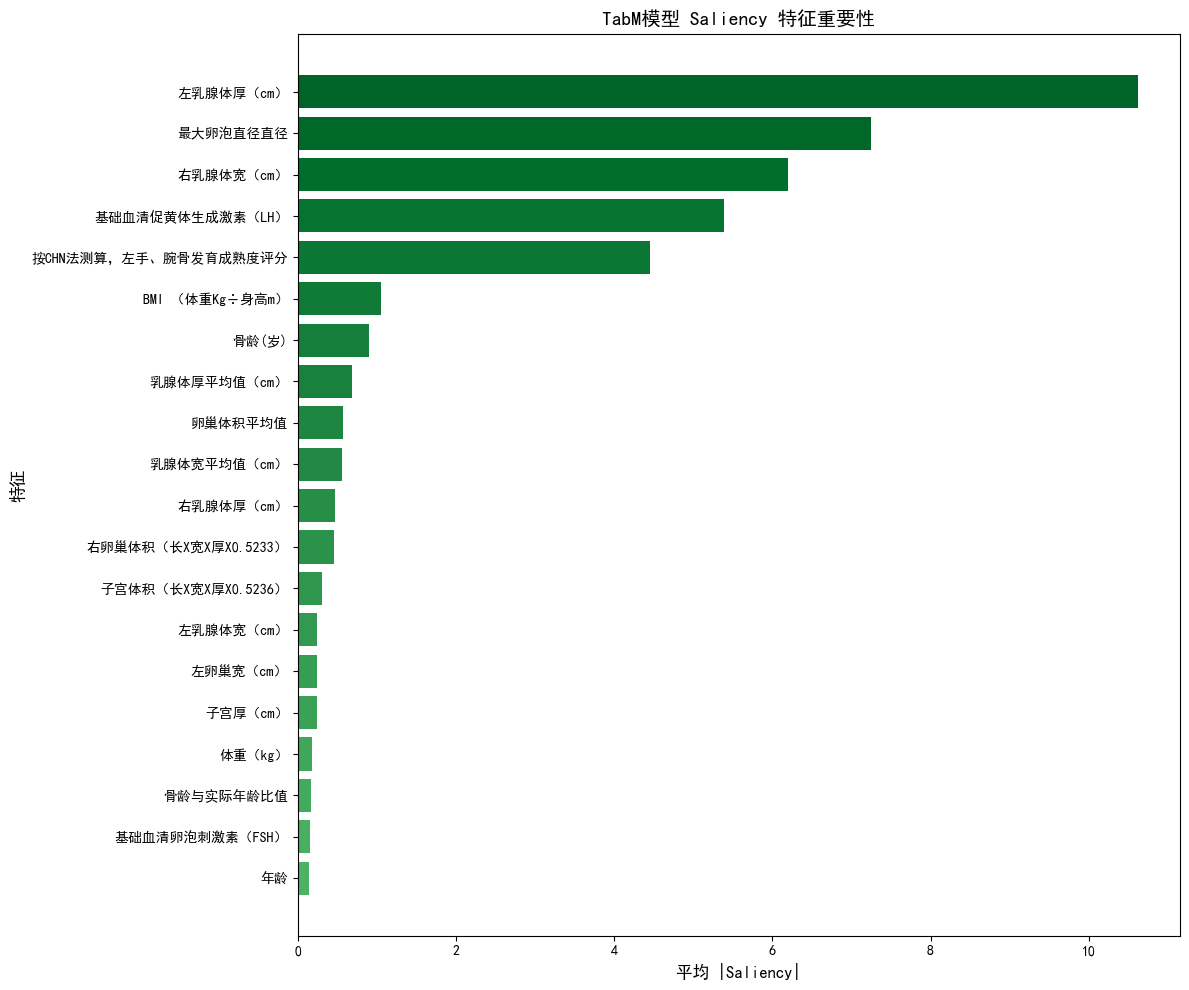

已保存: captum_saliency_importance.png/pdf


In [20]:
print("生成 Saliency 特征重要性图...")
sal_importance = np.abs(sal_attr_np).mean(axis=0)
sal_importance_df = pd.DataFrame(
    {"特征": feature_cols_processed, "Saliency重要性": sal_importance}
).sort_values("Saliency重要性", ascending=True)

plt.figure(figsize=(12, 10))
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(sal_importance_df)))
plt.barh(
    sal_importance_df["特征"].tail(20),
    sal_importance_df["Saliency重要性"].tail(20),
    color=colors[-20:],
)
plt.xlabel("平均 |Saliency|", fontsize=12)
plt.ylabel("特征", fontsize=12)
plt.title("TabM模型 Saliency 特征重要性", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/captum_saliency_importance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/captum_saliency_importance.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: captum_saliency_importance.png/pdf")

---
# LIME 局部可解释性分析

## 21. LIME 解释器

In [21]:
print("=" * 70)
print("LIME 局部可解释性分析")
print("=" * 70)

lime_explainer = LimeTabularExplainer(
    training_data=X_train_transformed,
    feature_names=feature_cols_processed,
    class_names=["正常", "早熟"],
    mode="classification",
    random_state=RANDOM_SEED,
)
print("LIME解释器创建成功！")

LIME 局部可解释性分析
LIME解释器创建成功！


## 22. LIME 单样本解释

In [22]:
print("生成 LIME 单样本解释...")
pos_idx = np.where(y_validation_binary == 1)[0][10]
neg_idx = np.where(y_validation_binary == 0)[0][10]

print("解释正类样本...")
exp_pos = lime_explainer.explain_instance(
    X_validation_transformed[pos_idx],
    predict_proba_numpy_2d,
    num_features=15,
    num_samples=1000,
)
print("解释负类样本...")
exp_neg = lime_explainer.explain_instance(
    X_validation_transformed[neg_idx],
    predict_proba_numpy_2d,
    num_features=15,
    num_samples=1000,
)
print("LIME解释计算完成！")

生成 LIME 单样本解释...
解释正类样本...
解释负类样本...
LIME解释计算完成！


生成 LIME 正类样本解释图...


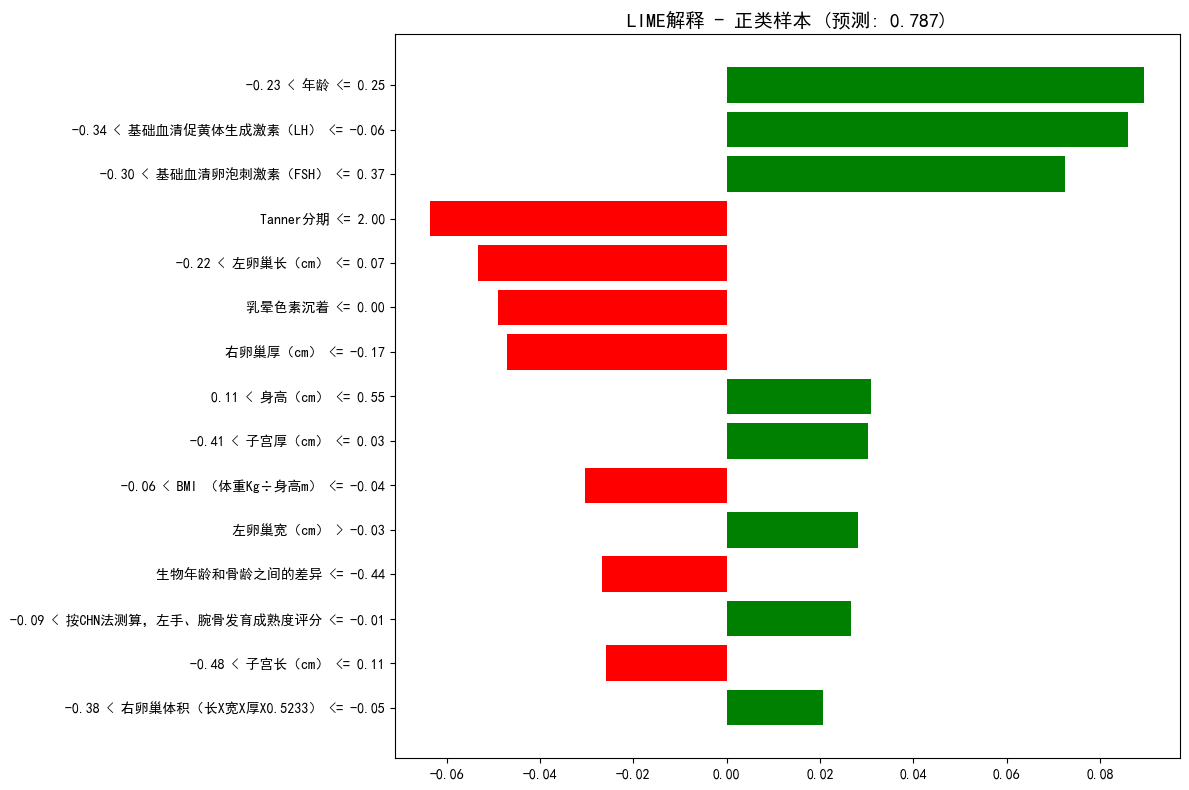

已保存: lime_positive_sample.png/pdf


In [23]:
print("生成 LIME 正类样本解释图...")
fig = exp_pos.as_pyplot_figure(label=1)
fig.set_size_inches(12, 8)
plt.title(
    f"LIME解释 - 正类样本 (预测: {predict_proba_numpy(X_validation_transformed[pos_idx:pos_idx+1])[0]:.3f})",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/lime_positive_sample.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/lime_positive_sample.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: lime_positive_sample.png/pdf")

生成 LIME 负类样本解释图...


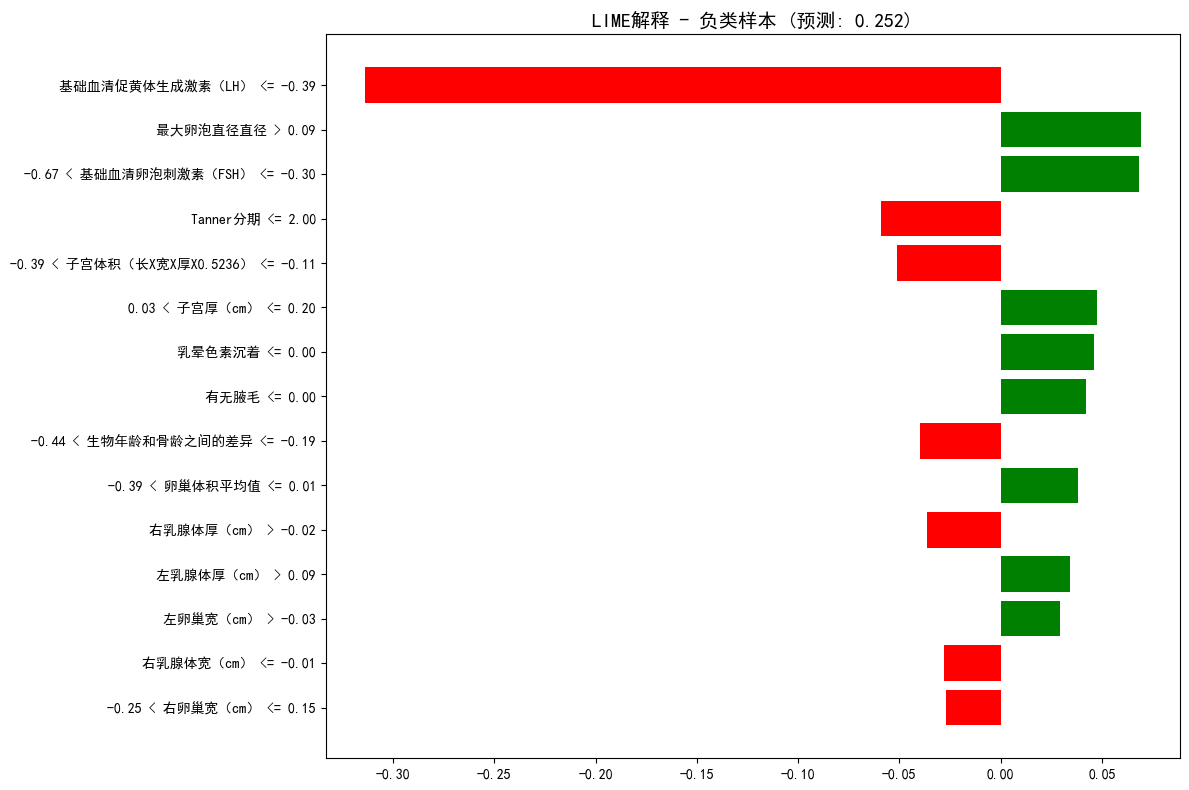

已保存: lime_negative_sample.png/pdf


In [24]:
print("生成 LIME 负类样本解释图...")
fig = exp_neg.as_pyplot_figure(label=1)
fig.set_size_inches(12, 8)
plt.title(
    f"LIME解释 - 负类样本 (预测: {predict_proba_numpy(X_validation_transformed[neg_idx:neg_idx+1])[0]:.3f})",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/lime_negative_sample.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/lime_negative_sample.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: lime_negative_sample.png/pdf")

---
# Permutation Importance

## 23. 排列重要性计算

In [30]:
print("=" * 70)
print("Permutation Importance 分析")
print("=" * 70)

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score


# 直接用模型预测
def fast_predict_proba(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = tabm_model(X_tensor, None)
        proba = torch.softmax(logits, dim=-1).mean(dim=1).cpu().numpy()
    return proba[:, 1]


# 子采样
n_samples = min(150, len(X_validation_transformed))
rng = np.random.RandomState(RANDOM_SEED)
sample_idx = rng.choice(len(X_validation_transformed), n_samples, replace=False)
X_val_subset = X_validation_transformed[sample_idx].copy()
y_val_subset = y_validation_binary.values[sample_idx]

# 基准分数
baseline_proba = fast_predict_proba(X_val_subset)
baseline_score = roc_auc_score(y_val_subset, baseline_proba)
print(f"基准 AUC: {baseline_score:.4f}, 样本数: {n_samples}")

# Permutation Importance
n_repeats = 3
n_features = X_val_subset.shape[1]
importances = np.zeros((n_features, n_repeats))

print(f"计算 Permutation Importance ({n_features}特征 × {n_repeats}次)...")
for feat_idx in tqdm(range(n_features), desc="特征"):
    original_col = X_val_subset[:, feat_idx].copy()
    for r in range(n_repeats):
        X_val_subset[:, feat_idx] = rng.permutation(original_col)
        perm_proba = fast_predict_proba(X_val_subset)
        perm_score = roc_auc_score(y_val_subset, perm_proba)
        importances[feat_idx, r] = baseline_score - perm_score
    X_val_subset[:, feat_idx] = original_col


# 构造结果
class PermResult:
    def __init__(self, imp):
        self.importances = imp
        self.importances_mean = imp.mean(axis=1)
        self.importances_std = imp.std(axis=1)


perm_result = PermResult(importances)
print("Permutation Importance 计算完成！")

Permutation Importance 分析
基准 AUC: 0.8957, 样本数: 150
计算 Permutation Importance (38特征 × 3次)...


特征:   0%|          | 0/38 [00:00<?, ?it/s]

Permutation Importance 计算完成！


生成 Permutation Importance 图...


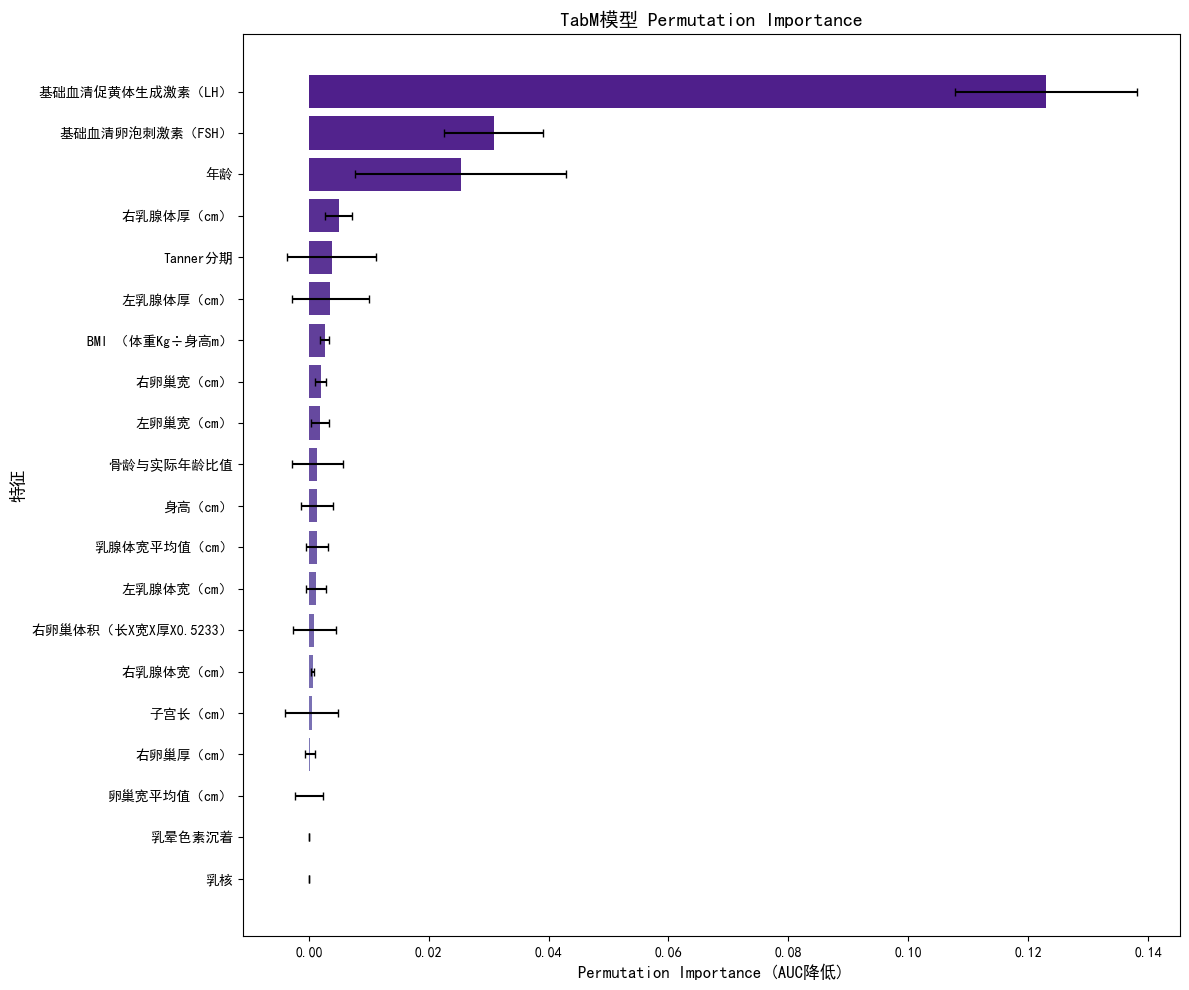

已保存: permutation_importance.png/pdf


In [31]:
print("生成 Permutation Importance 图...")
perm_importance_df = pd.DataFrame(
    {
        "特征": feature_cols_processed,
        "Perm重要性": perm_result.importances_mean,
        "Perm标准差": perm_result.importances_std,
    }
).sort_values("Perm重要性", ascending=True)

plt.figure(figsize=(12, 10))
colors = plt.cm.Purples(np.linspace(0.3, 0.9, len(perm_importance_df)))
plt.barh(
    perm_importance_df["特征"].tail(20),
    perm_importance_df["Perm重要性"].tail(20),
    xerr=perm_importance_df["Perm标准差"].tail(20),
    color=colors[-20:],
    capsize=3,
)
plt.xlabel("Permutation Importance (AUC降低)", fontsize=12)
plt.ylabel("特征", fontsize=12)
plt.title("TabM模型 Permutation Importance", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/permutation_importance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "./output/tabm_visualizations/permutation_importance.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("已保存: permutation_importance.png/pdf")

---
# 汇总分析

## 24. 多方法特征重要性对比

In [32]:
print("=" * 70)
print("多方法特征重要性汇总对比")
print("=" * 70)


# 归一化各方法的重要性到[0,1]
def normalize(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)


comparison_df = pd.DataFrame(
    {
        "特征": feature_cols_processed,
        "SHAP": normalize(mean_shap),
        "IntegratedGradients": normalize(ig_importance),
        "FeatureAblation": normalize(fa_importance),
        "Saliency": normalize(sal_importance),
        "Permutation": normalize(perm_result.importances_mean),
    }
)

# 计算平均排名
comparison_df["平均重要性"] = comparison_df[
    ["SHAP", "IntegratedGradients", "FeatureAblation", "Saliency", "Permutation"]
].mean(axis=1)
comparison_df = comparison_df.sort_values("平均重要性", ascending=False)

print("前6个最重要特征（多方法平均）：")
print(
    comparison_df.head(6)[
        ["特征", "SHAP", "IntegratedGradients", "Permutation", "平均重要性"]
    ].to_string(index=False)
)

# 保存汇总表
comparison_df.to_csv(
    "./output/tabm_visualizations/feature_importance_comparison.csv", index=False
)
print("\n已保存: feature_importance_comparison.csv")

多方法特征重要性汇总对比
前6个最重要特征（多方法平均）：
             特征     SHAP  IntegratedGradients  Permutation    平均重要性
基础血清促黄体生成激素（LH） 1.000000             1.000000     1.000000 0.901340
 基础血清卵泡刺激素（FSH） 0.579314             0.926611     0.286633 0.457278
             年龄 0.447383             0.632080     0.244373 0.359204
      左乳腺体厚（cm） 0.122645             0.348951     0.075792 0.353414
       最大卵泡直径直径 0.063597             0.253281     0.034910 0.239872
       Tanner分期 0.091988             0.124074     0.077630 0.211186

已保存: feature_importance_comparison.csv


## 25. 多方法重要性热力图

生成多方法重要性热力图...


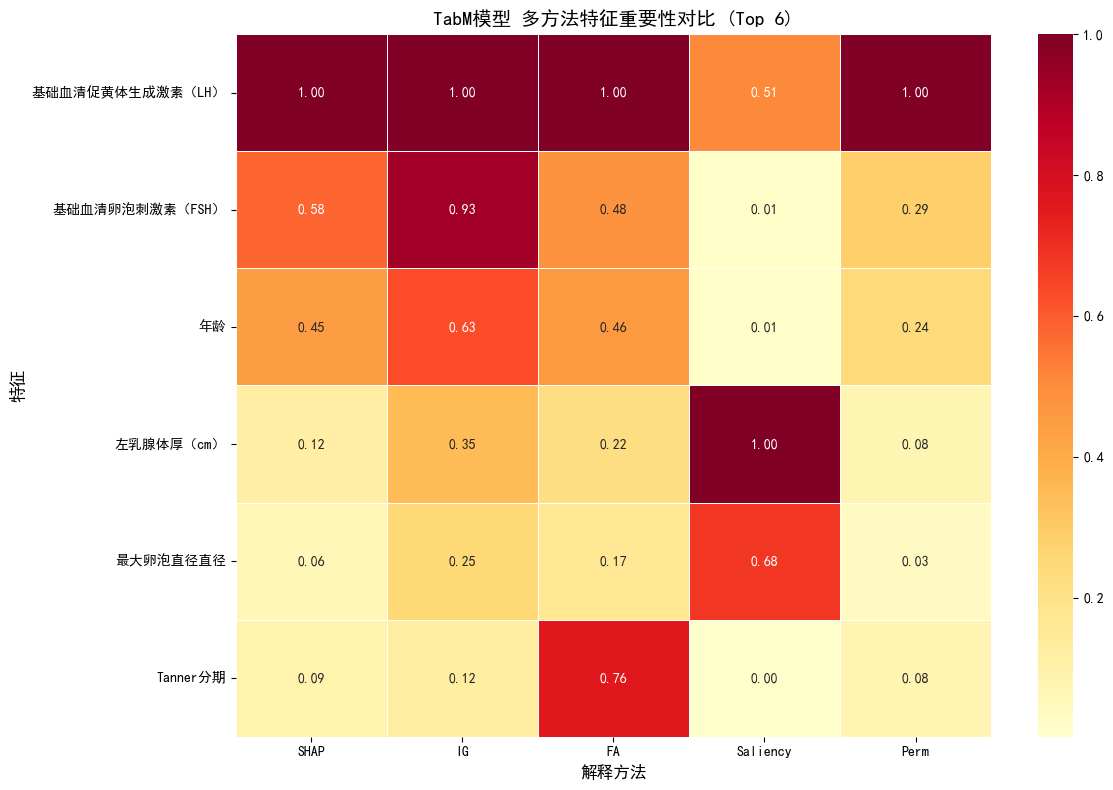

已保存: importance_heatmap.png/pdf


In [33]:
print("生成多方法重要性热力图...")

# 取前6个重要特征
top6 = comparison_df.head(6)
heatmap_data = top6.set_index("特征")[
    ["SHAP", "IntegratedGradients", "FeatureAblation", "Saliency", "Permutation"]
]

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0.5,
    xticklabels=["SHAP", "IG", "FA", "Saliency", "Perm"],
)
plt.title("TabM模型 多方法特征重要性对比 (Top 6)", fontsize=14, fontweight="bold")
plt.xlabel("解释方法", fontsize=12)
plt.ylabel("特征", fontsize=12)
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/importance_heatmap.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabm_visualizations/importance_heatmap.pdf", dpi=300, bbox_inches="tight"
)
plt.show()
print("已保存: importance_heatmap.png/pdf")

## 26. 多方法重要性雷达图

生成多方法重要性雷达图...


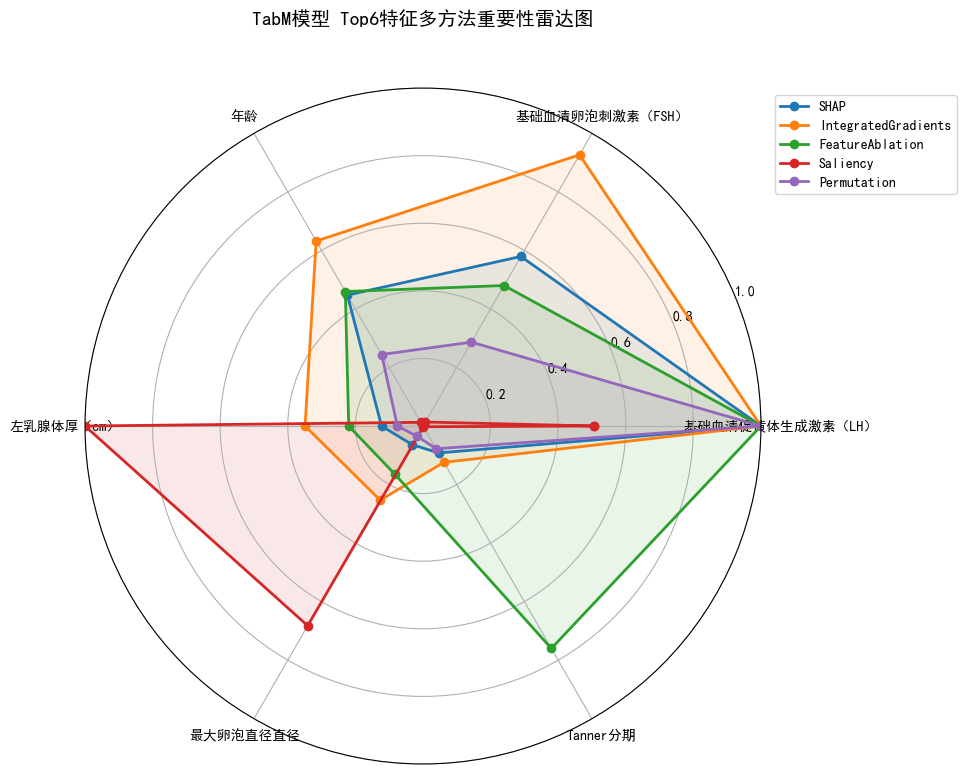

已保存: importance_radar.png/pdf


In [34]:
print("生成多方法重要性雷达图...")

# 取前6个重要特征做雷达图
top6 = comparison_df.head(6)
categories = top6["特征"].tolist()
N = len(categories)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

methods = ["SHAP", "IntegratedGradients", "FeatureAblation", "Saliency", "Permutation"]
colors_radar = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

for method, color in zip(methods, colors_radar):
    values = top6[method].tolist()
    values += values[:1]
    ax.plot(angles, values, "o-", linewidth=2, label=method, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))
plt.title("TabM模型 Top6特征多方法重要性雷达图", fontsize=14, fontweight="bold", y=1.08)
plt.tight_layout()
plt.savefig(
    "./output/tabm_visualizations/importance_radar.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabm_visualizations/importance_radar.pdf", dpi=300, bbox_inches="tight"
)
plt.show()
print("已保存: importance_radar.png/pdf")